In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from IPython.display import display
import warnings

%matplotlib inline

In [2]:
# We use this warn function to supress the sklearn warnings that will spam the output
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [3]:
# The dataset has been aquired from https://archive.ics.uci.edu/ml/datasets/Wholesale+customers
# In this dataset we will monitor the amount of spending each customer spends in each category. This can offer insight as to
# potentially what area of business the customer may be in and how to better serve said customer.

df = pd.read_csv('customers.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
# We want to look at all of the food categories only, so we can remove the Channel and Region columns. Also it is good for us 
# to learn the size of the dataset we would be dealing with.

df.drop(['Channel', 'Region'], axis=1, inplace=True)
df.shape

(440, 6)

In [5]:
# The describe method provides some basic statistics for each of the numeric columns (it just so happens that every column
# in our dataset is quantitative).

df.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [6]:
# Using the info method reveals if there is any null data in the dataframe and the datatypes of each column. Since all of our
# data is quantitative, then it is fine for them to all be store in int64's.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicatessen      440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


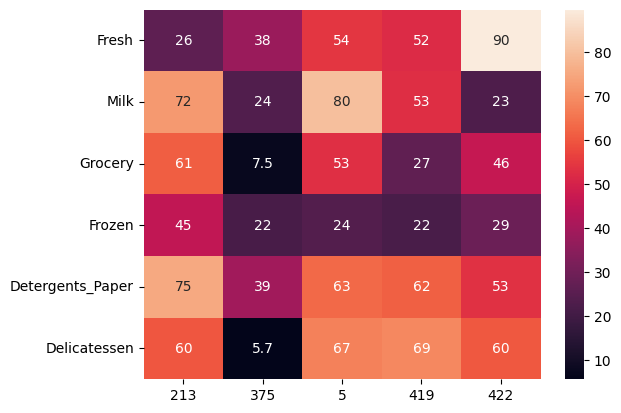

In [7]:
# Now we want to generate a random sample of indicies so we have a smaller sample of customers to look at rather than the
# whole dataset. We also look at the heatmap of the sampled customers to see how they rank in spending across each
# category. For example customer id 223, may be more of a retail grocery store since it spends a lot of money on an assortment
# of items. They also tend to spend less on fresh foods since they might perish and go to waste if no customer buys them.

random.seed(12345)
indicies = [random.randint(0, df.shape[0]) for i in range(5)]
sns.heatmap((df.rank(pct=True).loc[indicies]*100).transpose(), annot=True)
plt.show()

In [8]:
# Another good thing for us to look into would be how important each of the feature variables are in relation to the 
# other variables. So how we can accomplish this is by using all of the other columns of data to predict the dropped column.
# Then we can fit a regressor model to the data and finally we can look at the R2 score of the model. The lower the R2 score
# means that the model struggled to fit the relationship between the training and testing data. The closer to 1 the score is,
# the better the relationship. 

# Now for the potentially confusing part, the lower the R2 score means that the dropped column is very important and 
# the higher the R2 score, the less important that column is. For exmaple, Fresh appears to be a very important column 
# since all of the other columns (Milk, Grocery, Frozen, Detergents_Paper, and Delicatessen) combined struggled to 
# accurately predict the Fresh column. This means that the Fresh column may be useful when identifying customer spending 
# habits.

for col in df.columns:
    subset_df = df.drop([col], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(subset_df, df[col], test_size=.2, random_state=12345)
    regressor = DecisionTreeRegressor(random_state=12345).fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
    print(f'R2 Score for {col}: {score}')

R2 Score for Fresh: -0.8613147300387307
R2 Score for Milk: 0.5656703111040027
R2 Score for Grocery: 0.6789305246914461
R2 Score for Frozen: -0.5428492567812309
R2 Score for Detergents_Paper: 0.8266146173119908
R2 Score for Delicatessen: 0.14584649725933374


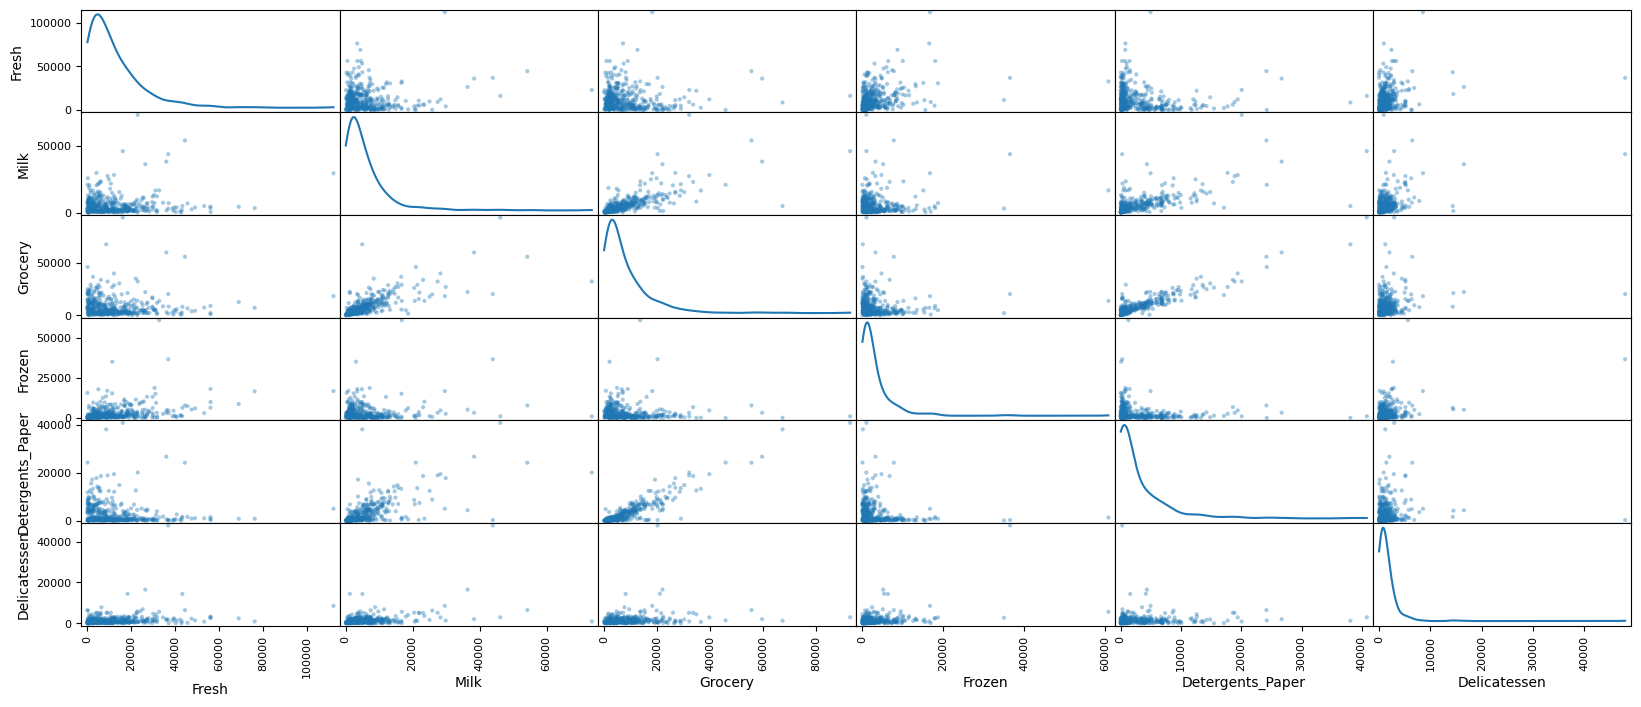

In [9]:
# Another good practice to do when dealing with data is to look at the distribution of the dataset. We can look at a scatter
# plot of each variable related to one another as well as a distribution of each variable (which is along the diagonal). This
# scatterplot is very revealing, for example it reveals that a lot of our data is heavily right skewed and we might want to
# consider using a log transformation on the dataset to attempt to normalize the data. 

pd.plotting.scatter_matrix(df, figsize=(20,8), alpha=0.4, diagonal='kde')
plt.show()

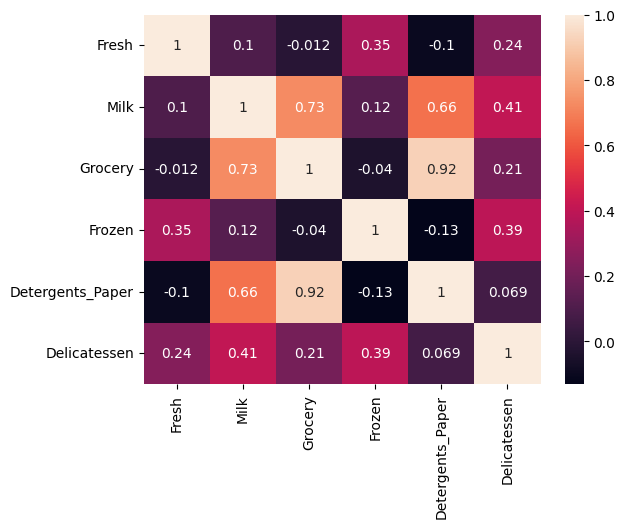

In [10]:
# We can also look at the correlation between each of the feature variables with each other. This reveals if there are
# potentially any relationships between any of the variables. For exmaple the Detergents_Paper appears to be strongly correlated
# to the Grocery variable and moderately correlated to the Milk category. This lines up with the R2 score from above meaning
# that this variable might not be as useful in segmentation compared to other variables.

sns.heatmap(df.corr(), annot=True)
plt.show()

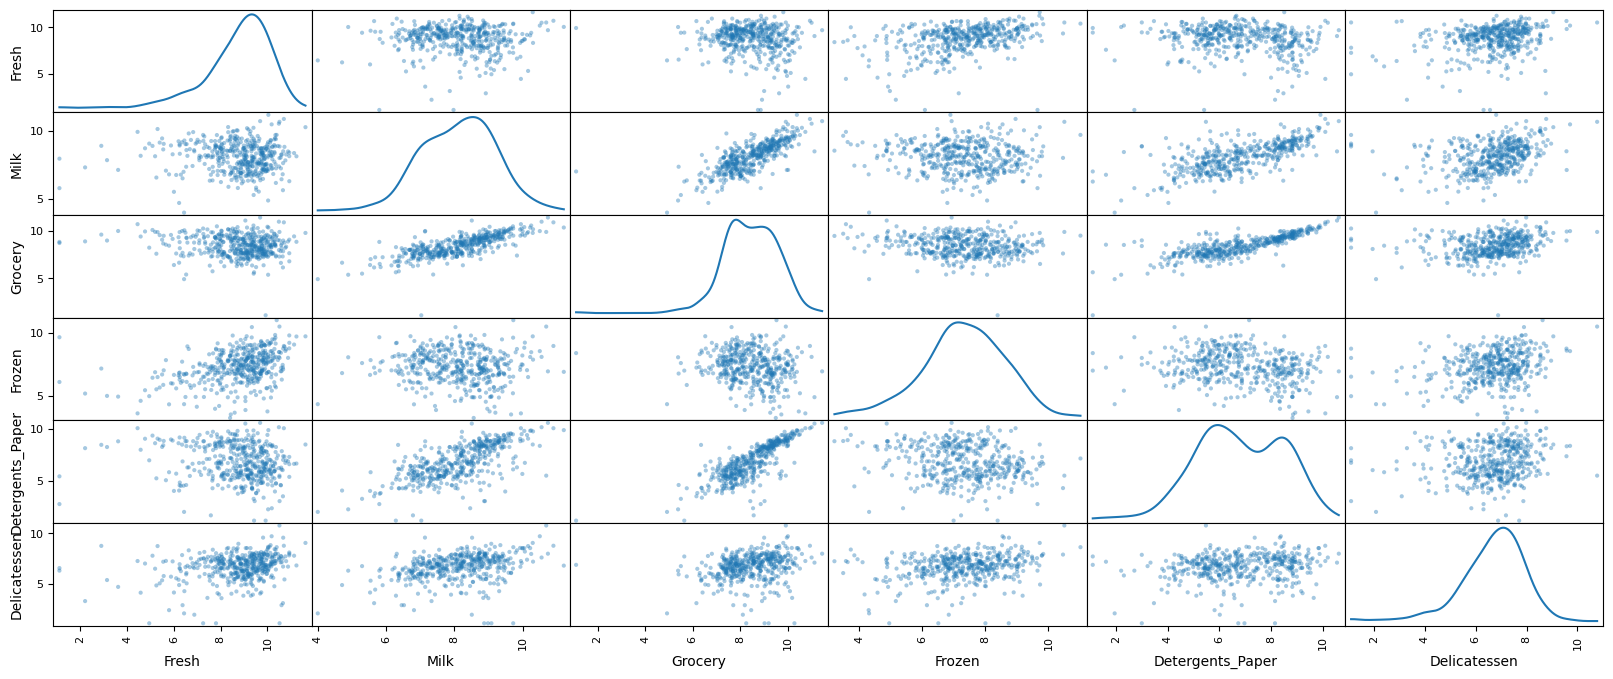

In [11]:
# We can log scale the dataset and look at the scatter matrix again. Now it the data distribution across all of the variables
# appear to be significantly closer to a normal distribution compared to earlier. 

log_df = np.log(df)
pd.plotting.scatter_matrix(log_df, figsize=(20,8), alpha=0.4, diagonal='kde')
plt.show()

In [12]:
# We can compare the small sample of data we took earlier across the non scaled and the log scaled dataframes. As you can see
# the values are significantly smaller in the log scaled dataframe but you can still maintain the relationship between the 
# points. For example, id 213 and 422 spend a similar amount at the Deli while 375 spends significantly less.

print('Normal Scaled for Sampled Indicies')
display(df.loc[indicies])
print()
print()
print('Log Scaled for Sample Indicies')
display(log_df.loc[indicies])

Normal Scaled for Sampled Indicies


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
213,3317,6602,6861,1329,3961,1215
375,5841,1450,1162,597,476,70
5,9413,8259,5126,666,1795,1451
419,8861,3783,2223,633,1580,1521
422,26400,1377,4172,830,948,1218




Log Scaled for Sample Indicies


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
213,8.106816,8.795128,8.833608,7.192182,8.284252,7.102499
375,8.672657,7.279319,7.057898,6.391917,6.165418,4.248495
5,9.149847,9.019059,8.542081,6.501290,7.492760,7.280008
419,9.089415,8.238273,7.706613,6.450470,7.365180,7.327123
422,10.181119,7.227662,8.336151,6.721426,6.854355,7.104965


Distribution before scaling the data


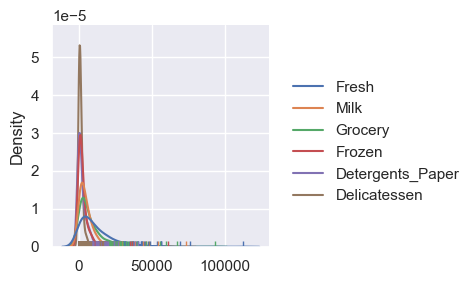

Distribution after log scaling the data


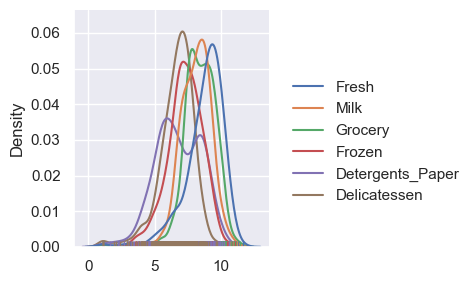

In [13]:
# Here is just a visual comparison of the distributions before and after the log scaling. As you can see, the log scaling 
# significantly helps with normalizing our dataset.

for i in range(2):
    sns.set(color_codes=True)
    if i == 0:
        print("Distribution before scaling the data")
        sns.displot(df, rug=True, kind='kde', height=3)
    else:
        print("Distribution after log scaling the data")
        sns.displot(log_df, rug=True, kind='kde', height=3)
    plt.show()

In [14]:
# Before going any further, no that we have normalized our dataset we want to remove any outliers that may affect our 
# segmentaiton. We can do this by calculating quartiles 1 and 3, then using that to calculate the inner quartile range (IQR). 
# After that, then the cutoff value is determined by 1.5 times our IQR. Then if any point is below Q1 - cutoff or greater than
# Q3 + cutoff, then the point is an outlier. We will do this across each of the columns to find all of the indexes that are 
# outliers in each column. Now this is up to user descretion but we will only remove outliers from our dataset that
# appear to be outliers for more than one column. If you wanted to you could remove them all but, I feel that the most important
# ones to get rid of are ones that impact more than one column. If need be we can always come back and be more strict and remove
# all outliers.

outliers = []
for col in log_df.keys():
    quartile_1 = np.percentile(log_df[col], 25)
    quartile_3 = np.percentile(log_df[col], 75)
    outlier_step = 1.5*(quartile_3-quartile_1)
    
    outliers_temp = log_df[(log_df[col] < (quartile_1-outlier_step)) | (log_df[col] > (quartile_3+outlier_step))]
    
    print(f'Outliers for {col}: {outliers_temp.index.to_list()}')
    display(outliers_temp)
    print()
    outliers += outliers_temp.index.to_list()
    
print(f'All total outliers: {list(set(outliers))}')

dup_outliers = list(set([outlier for outlier in outliers if outliers.count(outlier) > 1]))
print(f'All outliers that appear more than once: {dup_outliers}')
cleaned_log_data = log_df.drop(dup_outliers).reset_index(drop = True)
print(f'Amount of remaining cleaned data: {cleaned_log_data.shape[0]}')

Outliers for Fresh: [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382



Outliers for Milk: [86, 98, 154, 356]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275



Outliers for Grocery: [75, 154]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442



Outliers for Frozen: [38, 57, 65, 145, 175, 264, 325, 420, 429, 439]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244



Outliers for Detergents_Paper: [75, 161]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101



Outliers for Delicatessen: [66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372



All total outliers: [128, 264, 137, 142, 145, 154, 412, 285, 161, 289, 420, 38, 171, 429, 175, 304, 305, 439, 183, 57, 184, 187, 65, 66, 193, 325, 75, 203, 81, 338, 86, 343, 218, 95, 96, 353, 98, 355, 356, 357, 233, 109]
All outliers that appear more than once: [128, 65, 66, 75, 154]
Amount of remaining cleaned data: 435


In [15]:
def visualize_pca(data, pca):
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    pca_comp_df = pd.DataFrame(np.round(pca.components_, 4), columns = list(cleaned_log_data.keys()))
    pca_comp_df.index = dimensions

    fig, ax = plt.subplots(figsize = (12,6))
    pca_comp_df.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))
    plt.show()
    
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    return pd.concat([variance_ratios, pca_comp_df], axis = 1)

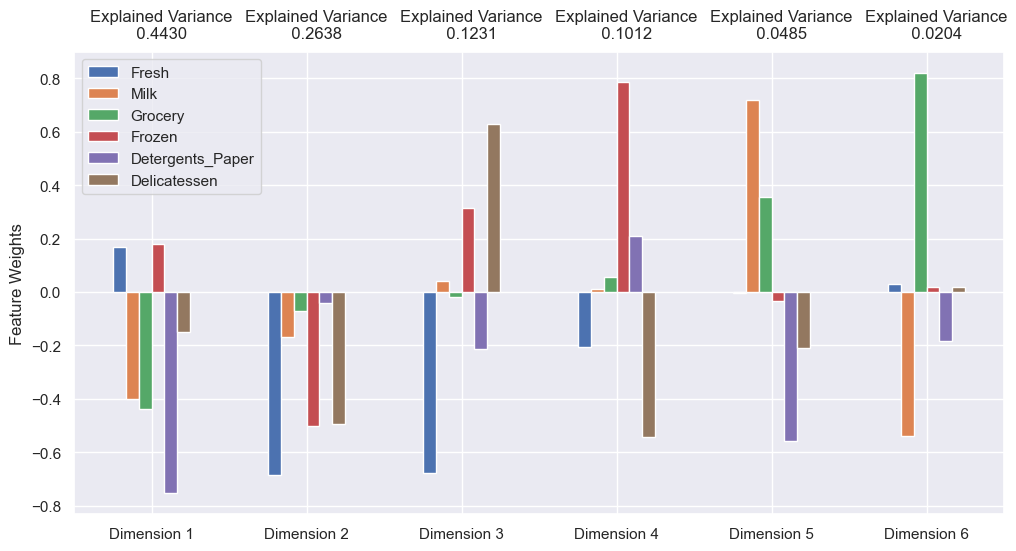

In [16]:
# Now we will apply PCA (Princial Component Analysis) to our scaled and cleaned dataset. I am going to try to explain PCA at 
# a very high level. Basically what PCA does is it tries to retain the relationship between points in space and maximizing 
# the explained variance for the features in a new dimensional space. That new dimensional space can be smaller than their 
# current dimensional space (which we didn't do in this case, yet, we just used it for maximizing variance). Now you are 
# probably wondering why somone would want to reduce dimensionality of their dataset, because that means they are reducing the 
# quality of their dataset comapred to the raw data. Well, the benefit of this method tries to maintain the quality of the data
# while reducing dimensions. That allows us to significantly reduce our data size and can significantly help with training
# and model prediction speeds. So this is a trade off you must consider but it can be super useful depending on how many 
# dimensions exist in your dataset.

# When plotting the explained variance for each of the dimensions, we can see that only really the fist two dimensions appear 
# to reduce variability the most. Then it appears to peter out. We can also look at it in a table for in the next cell, but
# what this is telling us is that the most significant dimensions for us would be 1 and 2 as they combined explain about
# 70% of the variance.

pca = PCA(n_components=6).fit(cleaned_log_data)
pca_samples = visualize_pca(cleaned_log_data, pca)

In [17]:
display(pca_samples)
print(pca_samples['Explained Variance'].cumsum())

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


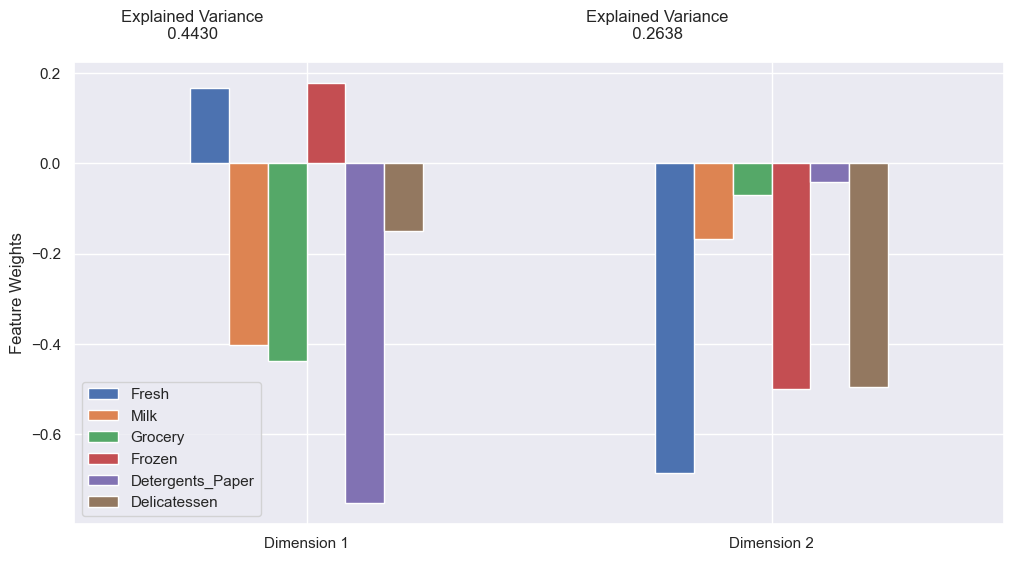

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941


In [18]:
# Just a note, as you can see here, we reduce the dimensionality of our dataset from 6 variables down to 2 while maintaining
# about 70% of the variance compared to having all 6 variables. Again, this is a tradeoff and is up to your discretion as to
# how many variables you would like to keep.

pca = PCA(n_components=2).fit(cleaned_log_data)
reduced_data = pca.transform(cleaned_log_data)
pca_samples = pca.transform(log_df.loc[indicies])
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

visualize_pca(cleaned_log_data, pca)

In [19]:
def biplot(good_data, reduced_data, pca):
    '''
    Biplot PCA logic aquired from https://github.com/teddyroland/python-biplot.
    '''

    fig, ax = plt.subplots(figsize = (12,6))
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    arrow_size, text_pos = 7.0, 8.0,

    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

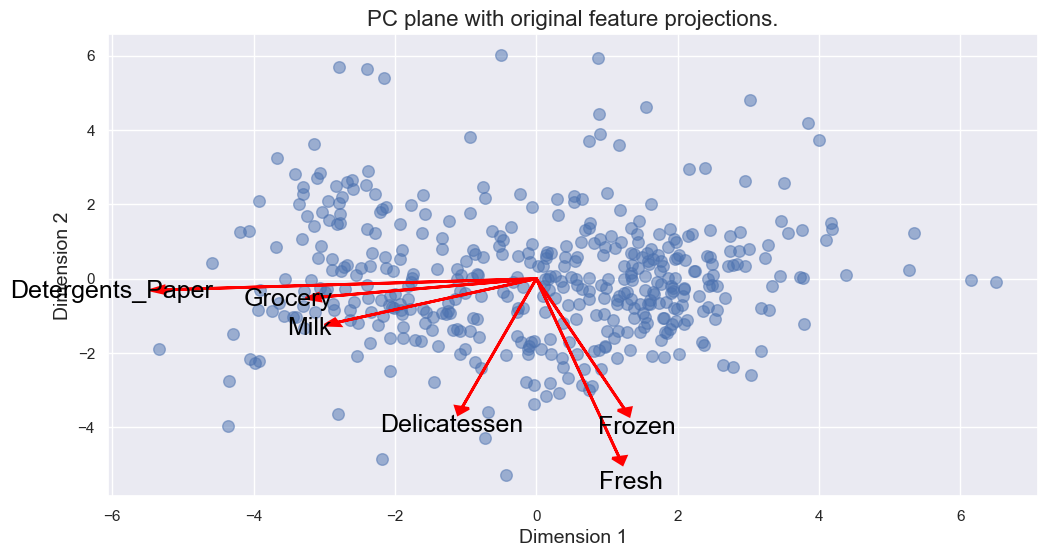

In [20]:
# We can see a little better of a PCA visualization here utilizng the PCA we did with only 2 componenets since the original 
# 6 appeared to not offer significant benefits over just having the first 2 dimensions. The blue dots on the plot represent 
# our compressed data now mapped from the 6 dimensional space we had before down to this two dimensional space and is 
# significantly easier to visualize. The closeness of the arrows reveal the similarity in the variables. For exmaple, earlier
# we mentioned the high correlation between Detergents Paper, Milk, and Grocery. As we can see here, all 3 of those arrows are
# closer together while farther away from the less correlated variables.

biplot(cleaned_log_data, reduced_data, pca)
plt.show()

In [21]:
# Now we will apply an unsupervised clustering algorithm on the dimensionality reduced data. Since we don't know the amount
# of clusters before hand we will try a few different clustering sizes and save their silhouette score to a dataframe. The
# silhouette coefficient tells us how good our clusters are. The closer to -1 the coefficient is to a point, the more 
# dissimilar that point is to a cluster, while the closer to 1 the more similar it is to other points in that cluster. 
# We will be looking at the mean of this coefficients for every point (silhouette score). After running the code, you will 
# see that 2 clusters appear to have the best results for our dataset. As we add more clusters the silhouette score gets 
# closer to 0 which means that the clusters are starting to overlap and become less significant. The closer the score is 
# to 1, the more distinct and well separated our clusters are. 

def produceGaussianMixture(k):
    clusterer = GaussianMixture(n_components=k, random_state=12345).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.means_ 
    sample_preds = clusterer.predict(pca_samples)
    score = silhouette_score(reduced_data,preds)
    return score

results = pd.DataFrame(columns=['Silhouette Score'])
results.columns.name = 'Number of Clusters'    
for k in range(2,13):
    score = produceGaussianMixture(k) 
    results = results.append(pd.DataFrame([score],columns=['Silhouette Score'],index=[k]))

display(results)

,Silhouette Score
2,0.421917
3,0.395557
4,0.321767
5,0.269199
6,0.331999
7,0.316894
8,0.318764
9,0.318737
10,0.324983
11,0.337279


In [22]:
# Now that we have settled on a cluster size of 2, we want to create a cluster model and fit it to our pca data.

clusterer = GaussianMixture(n_components=2, random_state=0).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.means_ 

In [23]:
# Next lets look at where the centers of these clusters lie with respect to each of our original 6 variables.

log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)

segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = df.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8953.0,2114.0,2765.0,2075.0,353.0,732.0
Segment 1,3552.0,7837.0,12219.0,870.0,4696.0,962.0


In [24]:
display(df.mean())

Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64

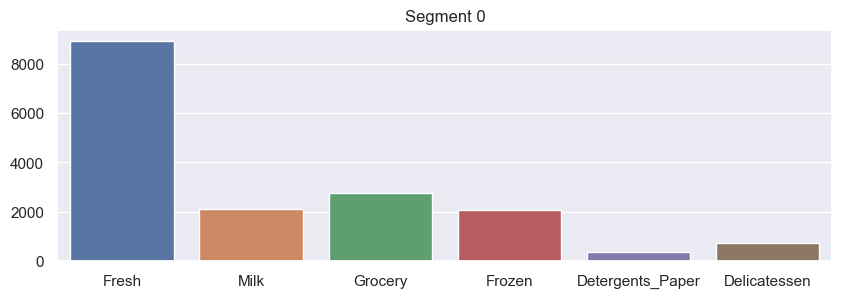

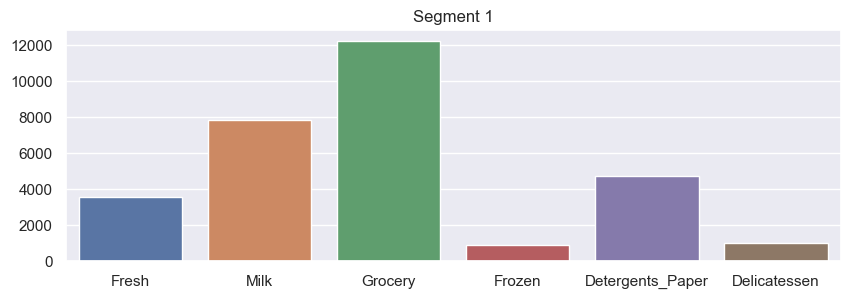

In [25]:
# We can plot our two segmented customer group center values to get a visual understanding for how the two groups appear to 
# differ. As we can see segment 0 appears to spend nearly all of thier money on fresh foods while spending minimal amounts
# on all other categories. Segment 1 spends minimal money on fresh, frozen, and deli foods but spends a lot on groceries and
# milk. Based off of this information, we can make an educated guess that maybe segment 0 represents restaurants since they
# purchase significant amount of fresh foods to serve to their customers, while also having minimal spending in most of the
# other categories respectively. Segment 1 may represent supermarkets since their spending is a little more well rounded and
# have a lower fresh spending due to the fact that if no customers buy the fresh foods, then they will spoil and go to waste.

plt.figure(figsize=(10,3))
plt.axes().set_title("Segment 0")
sns.barplot(x=true_centers.columns.values,y=true_centers.iloc[0].values)

plt.figure(figsize=(10,3))
plt.axes().set_title("Segment 1")
sns.barplot(x=true_centers.columns.values,y=true_centers.iloc[1].values)
plt.show()

In [26]:
# Let's look at our samples from much earlier to see what Cluster each of the customers fit into. As we can see, sample point 0
# and 2 spend a significantly more well rounded budget compared to sample point's 1, 3, and 4 spend significantly more of their
# budget on the fresh produce. This kind of lines up with the cluster centers from earlier.

sample_preds = clusterer.predict(pca_samples)

for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)
    
display(df.loc[indicies])

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1
Sample point 3 predicted to be in Cluster 0
Sample point 4 predicted to be in Cluster 0


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
213,3317,6602,6861,1329,3961,1215
375,5841,1450,1162,597,476,70
5,9413,8259,5126,666,1795,1451
419,8861,3783,2223,633,1580,1521
422,26400,1377,4172,830,948,1218
